In [16]:
import numpy as np
import pandas as pd
import awkward as awk
import uproot
import csv

import random
import itertools
import pickle

import matplotlib.pyplot as plt
params = {'legend.fontsize': 'large',
          'font.family': 'serif',
          'figure.figsize': (13,9),
          'axes.labelsize': 14,
          'axes.titlesize': 18,
          'xtick.labelsize': 14*0.75,
          'ytick.labelsize': 14*0.75}
plt.rcParams.update(params)

from waveformFuncs import getS1PodIndices, getS1PulsePodIndices, getS1Waveforms

## Files

In [3]:
rootFilePath = '/global/cfs/cdirs/lz/users/grischbi/MSSI/rfr_ffr_sims/'

filesFFR = ['FFR_output_20200410',
            'FFR_output_20200411',
            'FFR_output_20200412',
            'FFR_output_20200413',
            'FFR_output_20200414',
            'FFR_output_20200416',
            'FFR_output_20200418',
            'FFR_output_20200419']

filesRFR = ['RFR_output_20200410',
            'RFR_output_20200411',
            'RFR_output_20200412',
            'RFR_output_20200413',
            'RFR_output_20200414',
            'RFR_output_20200416',
            'RFR_output_20200418']

truthPathsFFR = [rootFilePath + file + '_mctruth.root' for file in filesFFR]
truthPathsRFR = [rootFilePath + file + '_mctruth.root' for file in filesRFR]

rootFilesFFR = [rootFilePath + file + '.root' for file in filesFFR]
rootFilesRFR = [rootFilePath + file + '.root' for file in filesRFR]

# Creating RFR and FFRs Pairs

## Goal: Match S1 pulses from both regions using position truth.

#### Read in truth data

In [4]:
truthBranches = ['mcTruthVertices.positionX_mm',
                 'mcTruthVertices.positionY_mm',
                 'mcTruthVertices.positionZ_mm']

### FFR

In [5]:
%%time

x_SS_FFR_list = []
y_SS_FFR_list = []
z_SS_FFR_list = []

for x_FFR, y_FFR, z_FFR in uproot.iterate(truthPathsFFR,
                                          treepath = 'RQMCTruth',
                                          branches = truthBranches,
                                          outputtype = tuple,
                                          entrysteps = float('inf')):
    
    singleScatterMask = x_FFR.counts == 1
    
    x_SS_FFR = x_FFR[singleScatterMask].flatten()
    y_SS_FFR = y_FFR[singleScatterMask].flatten()
    z_SS_FFR = z_FFR[singleScatterMask].flatten()
    
    x_SS_FFR_list.append(x_SS_FFR)
    y_SS_FFR_list.append(y_SS_FFR)
    z_SS_FFR_list.append(z_SS_FFR)

CPU times: user 892 ms, sys: 0 ns, total: 892 ms
Wall time: 3.04 s


In [6]:
x_FFRt = np.concatenate(x_SS_FFR_list)
y_FFRt = np.concatenate(y_SS_FFR_list)
z_FFRt = np.concatenate(z_SS_FFR_list)

### RFR

In [7]:
%%time

x_SS_RFR_list = []
y_SS_RFR_list = []
z_SS_RFR_list = []

for x_RFR, y_RFR, z_RFR in uproot.iterate(truthPathsRFR,
                                          treepath = 'RQMCTruth',
                                          branches = truthBranches,
                                          outputtype = tuple,
                                          entrysteps = float('inf')):
    
    singleScatterMask = x_RFR.counts == 1
    
    x_SS_RFR = x_RFR[singleScatterMask].flatten()
    y_SS_RFR = y_RFR[singleScatterMask].flatten()
    z_SS_RFR = z_RFR[singleScatterMask].flatten()
    
    x_SS_RFR_list.append(x_SS_RFR)
    y_SS_RFR_list.append(y_SS_RFR)
    z_SS_RFR_list.append(z_SS_RFR)

CPU times: user 737 ms, sys: 0 ns, total: 737 ms
Wall time: 1.12 s


In [8]:
x_RFRt = np.concatenate(x_SS_RFR_list)
y_RFRt = np.concatenate(y_SS_RFR_list)
z_RFRt = np.concatenate(z_SS_RFR_list)

### Radial distributions

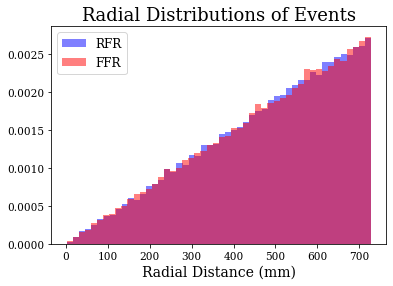

In [10]:
plt.hist(np.hypot(x_RFRt, y_RFRt), bins = 50, density = True, color = 'blue', alpha = 0.5, label = 'RFR')
plt.hist(np.hypot(x_FFRt, y_FFRt), bins = 50, density = True, color = 'red', alpha = 0.5, label = 'FFR')
plt.title('Radial Distributions of Events')
plt.legend()
plt.xlabel('Radial Distance (mm)')
plt.show()

#### Use FFR events at the bottom of the detector.

In [11]:
# Mask for lower part of detector
## Lower bound - Avoid field fringing effects very near the cathode
zMask1 = z_FFRt > 30
## Upper bound
zMask2 = z_FFRt < 250
zMask_FFR = np.logical_and(zMask1, zMask2)

In [12]:
f'{len(z_FFRt[zMask_FFR])}/{len(z_FFRt)} FFR events selected'

'12246/80928 FFR events selected'

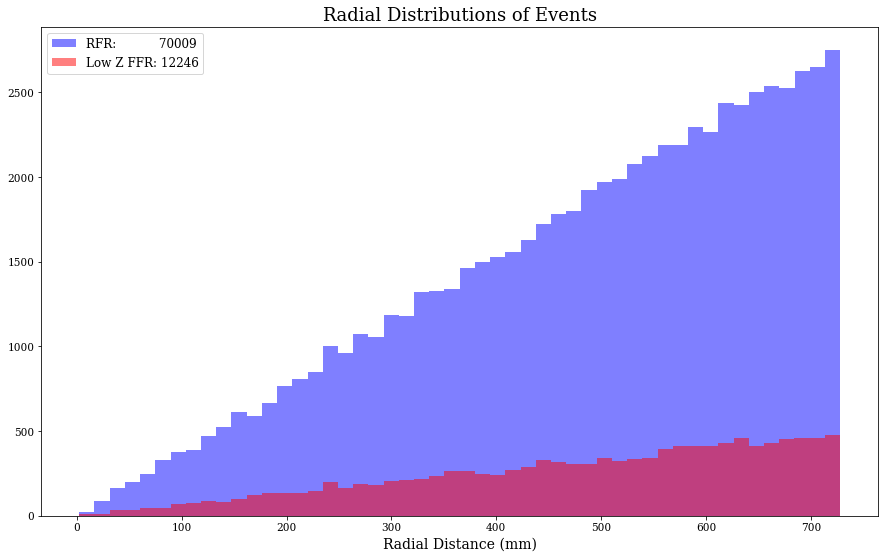

In [13]:
plt.figure(figsize = (15, 9))

plt.hist(np.hypot(x_RFRt, y_RFRt), bins = 50, density = False, color = 'blue', alpha = 0.5, label = 'RFR:           %s' % len(z_RFRt))
plt.hist(np.hypot(x_FFRt[zMask_FFR], y_FFRt[zMask_FFR]), bins = 50, density = False, color = 'red', alpha = 0.5, label = 'Low Z FFR: %s' % len(z_FFRt[zMask_FFR]))
plt.title('Radial Distributions of Events')
plt.legend(loc = 'upper left')
plt.xlabel('Radial Distance (mm)')
plt.show()

#### Binning events radially

In [14]:
radiusSquaredBins = np.arange(0, max((x_RFRt**2 + y_RFRt**2).max(), (x_FFRt**2 + y_FFRt**2).max()), 1000)

In [15]:
def eventsInRadialBins(x_, y_, radialBins_):
    """Collect events that occur in specific radial bins."""
    binnedEventIDs = []
    
    radialDistance = x_**2 + y_**2
    
    eventIDs_ = np.arange(len(x_))
        
    for i in range(len(radialBins_) - 1):
        binMask = np.logical_and(radialDistance >= radialBins_[i], radialDistance < radialBins_[i+1])
        binnedEventIDs.append(eventIDs_[binMask])
        
    return binnedEventIDs

In [16]:
binnedEventIDs_FFR = eventsInRadialBins(x_FFRt[zMask_FFR], y_FFRt[zMask_FFR], radiusSquaredBins)
binnedEventIDs_RFR = eventsInRadialBins(x_RFRt, y_RFRt, radiusSquaredBins)

In [17]:
# Make sure that there is at least one FFR event in each radial bin
all(len(l) != 0 for l in binnedEventIDs_FFR)

True

## Pairing according to radial bins

In [18]:
def pairingFunction(binnedIDs_FFR, binnedIDs_RFR):
    """Return list of paired event IDs"""
    
    pairList = []
    for eventIDsInradialBin_FFR, eventIDsInradialBin_RFR in zip(binnedIDs_FFR, binnedIDs_RFR):
        for eventID in eventIDsInradialBin_RFR:
            # For each RFR event, randomly choose an FFR event in the same radial bin
            pairList.append([eventID, random.choice(eventIDsInradialBin_FFR)])
            
    return np.array(pairList)

In [19]:
pairs = pairingFunction(binnedEventIDs_FFR, binnedEventIDs_RFR)

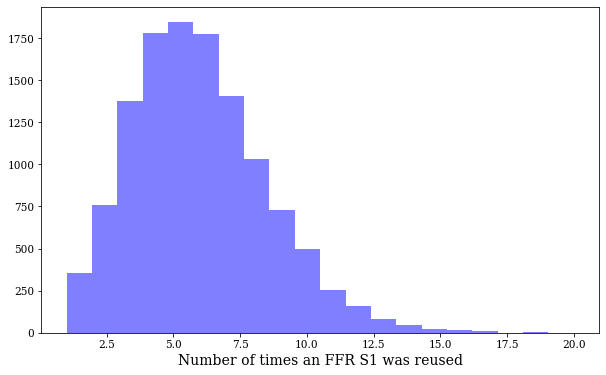

In [20]:
plt.figure(figsize = (10,6))
plt.hist(np.unique(pairs[:,1], return_counts = True)[1], bins = 20, color = 'blue', alpha = 0.5)
plt.xlabel('Number of times an FFR S1 was reused')
plt.show()

# Adding Paired Waveforms

## Goal: Add S1 waveforms according to the pairing

#### Read in waveform data

In [4]:
waveformFilePath = '/global/cfs/cdirs/lz/users/chami/GammaX/RFRvsFFRWaveforms/waveformData/'

waveformFileListFFR = ['FFR_1_waveforms.npy',
                       'FFR_2_waveforms.npy',
                       'FFR_3_waveforms.npy',
                       'FFR_4_waveforms.npy',
                       'FFR_5_waveforms.npy',
                       'FFR_6_waveforms.npy',
                       'FFR_7_waveforms.npy',
                       'FFR_8_waveforms.npy']

waveformFileListRFR = ['RFR_1_waveforms.npy',
                       'RFR_2_waveforms.npy',
                       'RFR_3_waveforms.npy',
                       'RFR_4_waveforms.npy',
                       'RFR_5_waveforms.npy',
                       'RFR_6_waveforms.npy',
                       'RFR_7_waveforms.npy']

waveformPathsFFR = [waveformFilePath + file for file in waveformFileListFFR]
waveformPathsRFR = [waveformFilePath + file for file in waveformFileListRFR]

### FFR

In [ ]:
waveformsFFR = np.load(waveformPathsFFR[0], allow_pickle = True)

for file in waveformPathsFFR[1:]:
    waveformsFFR = np.concatenate((waveformsFFR, np.load(file, allow_pickle = True)))

# Apply the z mask
waveformsFFR_masked = waveformsFFR[zMask_FFR]

In [6]:
normalizedWaveformsFFR = np.array([waveform / waveform.sum() for waveform in waveformsFFR])

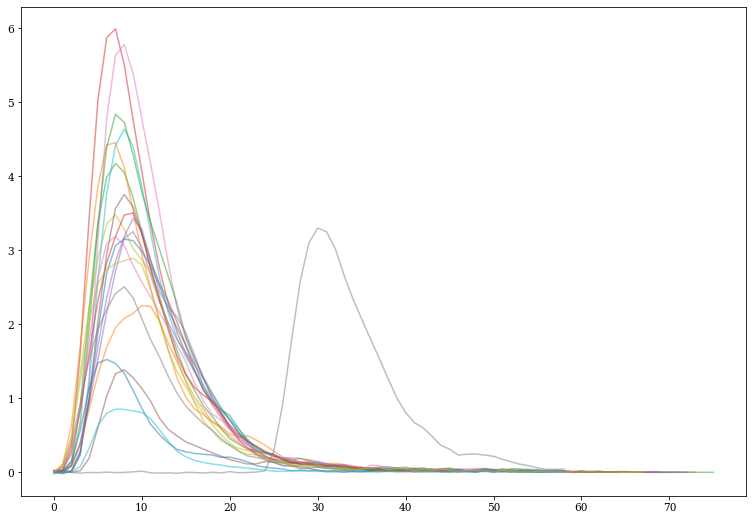

In [33]:
for i in range(20):
    plt.plot(longFFRs[i], alpha = 0.5)
plt.show()

### RFR

In [7]:
waveformsRFR = np.load(waveformPathsRFR[0], allow_pickle = True)

for file in waveformPathsRFR[1:]:
    waveformsRFR = np.concatenate((waveformsRFR, np.load(file, allow_pickle = True)))

In [ ]:
if len(waveformsFFR_masked) != len(x_FFRt[zMask_FFR]): 
    print("Number of FFR waveforms don't match")
else: 
    print("FFR Numbers match! %s FFR events." % len(waveformsFFR_masked))
    
if len(waveformsRFR) != len(x_RFRt): 
    print("Number of RFR waveforms don't match")
else:
    print("RFR Numbers match! %s RFR events." % len(x_RFRt))

In [26]:
def addWaveforms(waveforms_FFR, waveforms_RFR, pairs_):
    
    gXWaveforms = []
    
    AFT5IndicesFFR = getAFT5Index(waveforms_FFR)
    AFT5IndicesRFR = getAFT5Index(waveforms_RFR)
    
    for ID_RFR, ID_FFR in pairs_:
        
        # Select waveforms from a little before their AFT5 onward
        currentFFR = waveforms_FFR[ID_FFR][AFT5IndicesFFR[ID_FFR]:]
        currentRFR = waveforms_RFR[ID_RFR][AFT5IndicesRFR[ID_RFR]:]
        
        if len(currentFFR) > len(currentRFR):
            currentRFR = np.pad(currentRFR, (0, abs(len(currentFFR) - len(currentRFR))))
        elif len(currentFFR) < len(currentRFR):
            currentFFR = np.pad(currentFFR, (0, abs(len(currentFFR) - len(currentRFR))))
        
        gXWaveforms.append(currentFFR + currentRFR)
    
    return np.array(gXWaveforms)

def getAFT5Index(waveforms):
    """Return indices of AFT5"""
    AFT5Indices = np.zeros(len(waveforms), dtype = int)
    
    # First normalize
    normalizedWaveforms = np.array([w / w.sum() for w in waveforms])

    for i, waveform in enumerate(normalizedWaveforms):
        waveformCumSum = waveform.cumsum()
        startIndex = max(0, np.argmax(waveformCumSum > 0.05) - 5)
        AFT5Indices[i] = startIndex

    return AFT5Indices

In [27]:
%time waveformsGammaX = addWaveforms(waveformsFFR_masked, waveformsRFR, pairs)

CPU times: user 4.38 s, sys: 0 ns, total: 4.38 s
Wall time: 4.37 s


In [132]:
# Write waveforms to file
pickle.dump(waveformsGammaX, open("gXWaveforms.pkl", 'wb'))

In [44]:
normalizedWaveformsGammaX = np.array([waveform / waveform.sum() for waveform in waveformsGammaX])

#### Visualize some waveforms

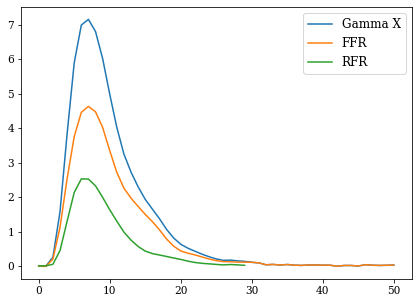

In [31]:
pairIndex = 1912

ffrAFT5Index = getAFT5Index(waveformsFFR_masked)
rfrAFT5Index = getAFT5Index(waveformsRFR)

plt.figure(figsize = (7, 5))
plt.plot(waveformsGammaX[pairIndex], label = 'Gamma X')
plt.plot(waveformsFFR_masked[pairs[pairIndex, 1]], label = 'FFR')
plt.plot(waveformsRFR[pairs[pairIndex, 0]], label = 'RFR')
plt.legend()
plt.show()

# Calculate RQs

### Read in RQs

Read in some simple RQs that are to be used in the analysis.

In [38]:
picklePath = !pwd
picklePath = picklePath[0] + '/intermediatePickles/'

In [39]:
simpleRQList = ['pulsesTPC.pulseArea_phd',
                'pulsesTPC.topBottomAsymmetry',
                'pulsesTPC.s1Probability']

#### FFR

In [34]:
%%time

S1c_FFRlist = []
TBA_FFRlist = []

for (S1c, TBA, s1Probability), z in zip(uproot.iterate(rootFilesFFR,
                                                       treepath = 'Events',
                                                       branches = simpleRQList,
                                                       outputtype = tuple,
                                                       entrysteps = float('inf'),
                                                       ), 
                                        uproot.iterate(truthPathsFFR,
                                                       treepath = 'RQMCTruth',
                                                       branches = 'mcTruthVertices.positionZ_mm',
                                                       outputtype = tuple,
                                                       entrysteps = float('inf'),
                                                       )):
    
    # Pulse and SS masks
    s1Mask = s1Probability.argmax()
    singleScatterMask = z[0].counts == 1
    
    S1c_FFRlist.append(S1c[s1Mask][singleScatterMask].flatten())
    TBA_FFRlist.append(TBA[s1Mask][singleScatterMask].flatten())

S1c_FFR = np.concatenate(S1c_FFRlist)
TBA_FFR = np.concatenate(TBA_FFRlist)

CPU times: user 7.81 s, sys: 781 ms, total: 8.59 s
Wall time: 1min 13s


In [33]:
pickle.dump(S1c_FFR, open("S1c_FFR.pkl", "wb"))
pickle.dump(TBA_FFR, open("TBA_FFR.pkl", "wb"))

In [40]:
with open(picklePath + "S1c_FFR.pkl", 'rb') as f:
    S1c_FFR = pickle.load(f)
with open(picklePath + "TBA_FFR.pkl", 'rb') as f:
    TBA_FFR = pickle.load(f)

#### RFR

In [34]:
%%time

S1c_RFRlist = []
TBA_RFRlist = []

for (S1c, TBA, s1Probability), z in zip(uproot.iterate(rootFilesRFR,
                                                       treepath = 'Events',
                                                       branches = simpleRQList,
                                                       outputtype = tuple,
                                                       entrysteps = float('inf'),
                                                       ), 
                                        uproot.iterate(truthPathsRFR,
                                                       treepath = 'RQMCTruth',
                                                       branches = 'mcTruthVertices.positionZ_mm',
                                                       outputtype = tuple,
                                                       entrysteps = float('inf'),
                                                       )):
    
    # Pulse and SS masks
    s1Mask = s1Probability.argmax()
    singleScatterMask = z[0].counts == 1
    
    S1c_RFRlist.append(S1c[s1Mask][singleScatterMask].flatten())
    TBA_RFRlist.append(TBA[s1Mask][singleScatterMask].flatten())

S1c_RFR = np.concatenate(S1c_RFRlist)
TBA_RFR = np.concatenate(TBA_RFRlist)

CPU times: user 6.61 s, sys: 411 ms, total: 7.02 s
Wall time: 42 s


In [35]:
pickle.dump(S1c_RFR, open("S1c_RFR.pkl", "wb"))
pickle.dump(TBA_RFR, open("TBA_RFR.pkl", "wb"))

In [41]:
with open(picklePath + "S1c_RFR.pkl", 'rb') as f:
    S1c_RFR = pickle.load(f)
with open(picklePath + "TBA_RFR.pkl", 'rb') as f:
    TBA_RFR = pickle.load(f)

### 1. Area Fraction Times

In [42]:
def calculateAFTs(waveformArray):
    AFTsFractionList = np.array([1, 5, 10, 25, 50, 75, 90, 95, 99]) / 100
    
    AFTs = np.zeros((len(waveformArray), len(AFTsFractionList))).astype(int)
    
    for i, waveform in enumerate(waveformArray):
        waveformCumSum = waveform.cumsum()
        AFTs[i] = [np.argmax(waveformCumSum > AFTFraction) for AFTFraction in AFTsFractionList]
    
    return AFTs * 10

In [45]:
%time gXAFTs = calculateAFTs(normalizedWaveformsGammaX)

CPU times: user 2.96 s, sys: 59.7 ms, total: 3.02 s
Wall time: 2.94 s


In [46]:
%time FFR_AFTs = calculateAFTs(normalizedWaveformsFFR)

CPU times: user 3.32 s, sys: 105 ms, total: 3.42 s
Wall time: 3.33 s


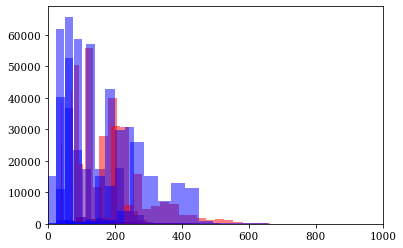

In [59]:
for gxAFT, ffrAFT in zip(gXAFTs.T, FFR_AFTs.T):
    plt.hist(gxAFT, bins = 100, color = 'red', alpha = 0.5)
    plt.hist(ffrAFT, bins = 100, color = 'blue', alpha = 0.5)
plt.xlim((0,1000))
plt.show()

Specifically, we would like to work with differences in the AFTs, rather than the raw values, to minimize correlations.
Also, don't use AFT1 and AFT99.

### 2. TBA

Combine TBA for paired pulses to make a gX TBA.

In [113]:
# Convenience function for weighted average
def weightedAverageForPairs(FFR, RFR, weights_FFR, weights_RFR, pairings):
    weightedAverage = np.zeros(len(pairings))
    
    for i, (indexRFR, indexFFR) in enumerate(pairings):
        weightedAverage[i] = (FFR[indexFFR] * weights_FFR[indexFFR] + RFR[indexRFR] * weights_RFR[indexRFR]) / (weights_FFR[indexFFR] + weights_RFR[indexRFR])
        
    return weightedAverage

In [114]:
%time gXTBA = weightedAverageForPairs(TBA_FFR[zMask_FFR], TBA_RFR, S1c_FFR[zMask_FFR], S1c_RFR, pairs)

CPU times: user 325 ms, sys: 0 ns, total: 325 ms
Wall time: 432 ms


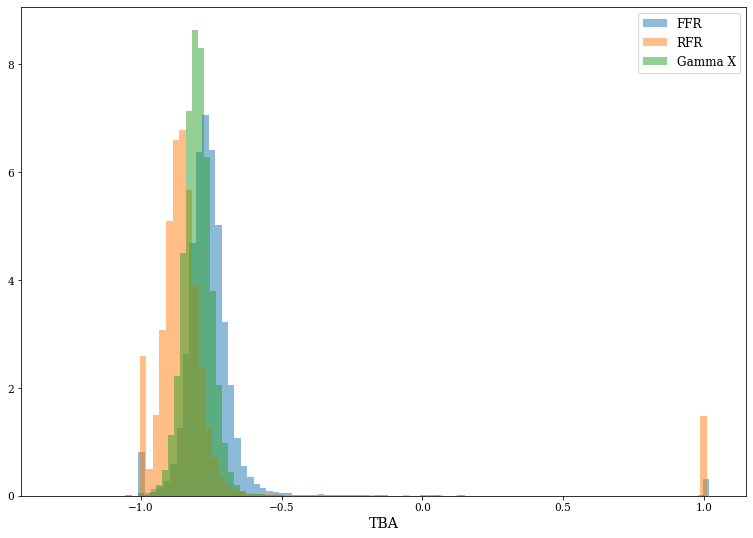

In [115]:
plt.hist(TBA_FFR[zMask_FFR], bins = 100, density = True, alpha = 0.5, label = 'FFR')
plt.hist(TBA_RFR, bins = 100, density = True, alpha = 0.5, label = "RFR")
plt.hist(gXTBA, bins = 100, density = True, alpha = 0.5, label = 'Gamma X')
plt.legend()
plt.xlabel('TBA')
plt.show()

### 3. Cluster Size and Peak Fractions

In [116]:
channelBranches = ['pulsesTPC.chID', 
                   'pulsesTPC.chPulseArea_phd',
                   'pulsesTPC.bottomCentroidX_cm',
                   'pulsesTPC.bottomCentroidY_cm',
                   'pulsesTPC.bottomArea_phd',
                   'pulsesTPC.topArea_phd',
                   'pulsesTPC.s1Probability']

#### FFR

In [130]:
%%time

chIDs_FFRlist = []
chAreas_FFRlist = []
xCentroids_FFRlist = []
yCentroids_FFRlist = []
bottomAreas_FFRlist = []
topAreas_FFRlist = []

fileNumber = 1

for (chIDs, chAreas, xCen, yCen, bArea, tArea, s1Probability), z in zip(uproot.iterate(rootFilesFFR,
                                                                                       treepath = 'Events',
                                                                                       branches = channelBranches,
                                                                                       outputtype = tuple,
                                                                                       entrysteps = float('inf'),
                                                                                       ), 
                                                                        uproot.iterate(truthPathsFFR,
                                                                                       treepath = 'RQMCTruth',
                                                                                       branches = 'mcTruthVertices.positionZ_mm',
                                                                                       outputtype = tuple,
                                                                                       entrysteps = float('inf'),
                                                                                       )):
    
    # Pulse and SS masks
    s1Mask = s1Probability.argmax()
    singleScatterMask = z[0].counts == 1
    
    chIDs = awk.fromiter(chIDs)
    chAreas = awk.fromiter(chAreas)
    
    chIDs_FFRlist.append(chIDs[s1Mask][singleScatterMask])
    chAreas_FFRlist.append(chAreas[s1Mask][singleScatterMask])
    
    xCentroids_FFRlist.append(xCen[s1Mask][singleScatterMask].flatten())
    yCentroids_FFRlist.append(yCen[s1Mask][singleScatterMask].flatten())
    bottomAreas_FFRlist.append(bArea[s1Mask][singleScatterMask].flatten())
    topAreas_FFRlist.append(tArea[s1Mask][singleScatterMask].flatten())
    
    print('File number %s processed!\n' % fileNumber)
    fileNumber += 1

chIDs_FFR = list(itertools.chain.from_iterable(chIDs_FFRlist))
chAreas_FFR = list(itertools.chain.from_iterable(chAreas_FFRlist))
    
xCentroids_FFR = np.concatenate(xCentroids_FFRlist)
yCentroids_FFR = np.concatenate(yCentroids_FFRlist)
bottomAreas_FFR = np.concatenate(bottomAreas_FFRlist)
topAreas_FFR = np.concatenate(topAreas_FFRlist)

File number 1 processed!

File number 2 processed!

File number 3 processed!

File number 4 processed!

File number 5 processed!

File number 6 processed!

File number 7 processed!

File number 8 processed!

CPU times: user 13min 56s, sys: 17 s, total: 14min 13s
Wall time: 15min 27s


In [132]:
%%time

# Write these to files
pickle.dump(chIDs_FFR, open("chID_FFR.pkl", "wb"))
pickle.dump(chAreas_FFR, open("chAreas_FFR.pkl", "wb"))
pickle.dump(xCentroids_FFR, open("xCen_FFR.pkl", "wb"))
pickle.dump(yCentroids_FFR, open("yCen_FFR.pkl", "wb"))
pickle.dump(bottomAreas_FFR, open("bAreas_FFR.pkl", "wb"))
pickle.dump(topAreas_FFR, open("tAreas_FFR.pkl", "wb"))

CPU times: user 21.1 s, sys: 588 ms, total: 21.7 s
Wall time: 21.7 s


In [117]:
%%time
# Load pickled files
with open(picklePath + "chID_FFR.pkl", 'rb') as f:
    chIDs_FFR = pickle.load(f)
with open(picklePath + "chAreas_FFR.pkl", 'rb') as f:
    chAreas_FFR = pickle.load(f)
with open(picklePath + "xCen_FFR.pkl", 'rb') as f:    
    xCentroids_FFR = pickle.load(f)
with open(picklePath + "yCen_FFR.pkl", 'rb') as f:  
    yCentroids_FFR = pickle.load(f)
with open(picklePath + "bAreas_FFR.pkl", 'rb') as f:  
    bottomAreas_FFR = pickle.load(f)
with open(picklePath + "tAreas_FFR.pkl", 'rb') as f:  
    topAreas_FFR = pickle.load(f)

CPU times: user 1min 13s, sys: 1.36 s, total: 1min 14s
Wall time: 1min 15s


In [118]:
%%time
# Convert to numpy arrays
chIDs_FFR = np.array(chIDs_FFR).flatten()
chAreas_FFR = np.array(chAreas_FFR).flatten()

CPU times: user 49.1 s, sys: 1.06 s, total: 50.2 s
Wall time: 51.2 s


#### RFR

In [118]:
%%time

chIDs_RFRlist = []
chAreas_RFRlist = []
xCentroids_RFRlist = []
yCentroids_RFRlist = []
bottomAreas_RFRlist = []
topAreas_RFRlist = []

for (chIDs, chAreas, xCen, yCen, bArea, tArea, s1Probability), z in zip(uproot.iterate(rootFilesRFR,
                                                                                       treepath = 'Events',
                                                                                       branches = channelBranches,
                                                                                       outputtype = tuple,
                                                                                       entrysteps = float('inf'),
                                                                                       ), 
                                                                        uproot.iterate(truthPathsRFR,
                                                                                       treepath = 'RQMCTruth',
                                                                                       branches = 'mcTruthVertices.positionZ_mm',
                                                                                       outputtype = tuple,
                                                                                       entrysteps = float('inf'),
                                                                                       )):
    
    # Pulse and SS masks
    s1Mask = s1Probability.argmax()
    singleScatterMask = z[0].counts == 1
    
    chIDs = awk.fromiter(chIDs)
    chAreas = awk.fromiter(chAreas)
    
    chIDs_RFRlist.append(chIDs[s1Mask][singleScatterMask])
    chAreas_RFRlist.append(chAreas[s1Mask][singleScatterMask])
    
    xCentroids_RFRlist.append(xCen[s1Mask][singleScatterMask].flatten())
    yCentroids_RFRlist.append(yCen[s1Mask][singleScatterMask].flatten())
    bottomAreas_RFRlist.append(bArea[s1Mask][singleScatterMask].flatten())
    topAreas_RFRlist.append(tArea[s1Mask][singleScatterMask].flatten())

chIDs_RFR = list(itertools.chain.from_iterable(chIDs_RFRlist))
chAreas_RFR = list(itertools.chain.from_iterable(chAreas_RFRlist))
    
xCentroids_RFR = np.concatenate(xCentroids_RFRlist)
yCentroids_RFR = np.concatenate(yCentroids_RFRlist)
bottomAreas_RFR = np.concatenate(bottomAreas_RFRlist)
topAreas_RFR = np.concatenate(topAreas_RFRlist)

CPU times: user 1min 50s, sys: 2.36 s, total: 1min 52s
Wall time: 2min 30s


In [133]:
%%time

# Write these to files
pickle.dump(chIDs_RFR, open("chID_RFR.pkl", "wb"))
pickle.dump(chAreas_RFR, open("chAreas_RFR.pkl", "wb"))
pickle.dump(xCentroids_RFR, open("xCen_RFR.pkl", "wb"))
pickle.dump(yCentroids_RFR, open("yCen_RFR.pkl", "wb"))
pickle.dump(bottomAreas_RFR, open("bAreas_RFR.pkl", "wb"))
pickle.dump(topAreas_RFR, open("tAreas_RFR.pkl", "wb"))

CPU times: user 17.9 s, sys: 148 ms, total: 18.1 s
Wall time: 18.2 s


In [119]:
%%time
# Load pickled files
with open(picklePath + "chID_RFR.pkl", 'rb') as f:
    chIDs_RFR = pickle.load(f)
with open(picklePath + "chAreas_RFR.pkl", 'rb') as f:
    chAreas_RFR = pickle.load(f)
with open(picklePath + "xCen_RFR.pkl", 'rb') as f:    
    xCentroids_RFR = pickle.load(f)
with open(picklePath + "yCen_RFR.pkl", 'rb') as f:  
    yCentroids_RFR = pickle.load(f)
with open(picklePath + "bAreas_RFR.pkl", 'rb') as f:  
    bottomAreas_RFR = pickle.load(f)
with open(picklePath + "tAreas_RFR.pkl", 'rb') as f:  
    topAreas_RFR = pickle.load(f)

CPU times: user 1min 3s, sys: 1.09 s, total: 1min 4s
Wall time: 1min 6s


In [120]:
%%time 
# Convert to numpy arrays
chIDs_RFR = np.array(chIDs_RFR).flatten()
chAreas_RFR = np.array(chAreas_RFR).flatten()

CPU times: user 41.7 s, sys: 645 ms, total: 42.4 s
Wall time: 43.1 s


In [121]:
pulseFFR = (chIDs_FFR[zMask_FFR], chAreas_FFR[zMask_FFR], xCentroids_FFR[zMask_FFR], yCentroids_FFR[zMask_FFR], bottomAreas_FFR[zMask_FFR], topAreas_FFR[zMask_FFR])
pulseRFR  = (chIDs_RFR, chAreas_RFR, xCentroids_RFR, yCentroids_RFR, bottomAreas_RFR, topAreas_RFR)

%time combinedRQs = combineChannelRQs(pulseFFR, pulseRFR, pairs)

CPU times: user 3min 10s, sys: 3.25 s, total: 3min 14s
Wall time: 3min 15s


In [122]:
%time gXDerivedRQs = RQ_func(combinedRQs)

CPU times: user 1min 25s, sys: 377 ms, total: 1min 25s
Wall time: 1min 26s


In [123]:
gXClusterSize, gXPeakFractionTop, gXPeakFractionBottom = gXDerivedRQs

#### Create FFR RQs

In [31]:
%%time 

pulseFFRUnmasked = (chIDs_FFR, chAreas_FFR, xCentroids_FFR, yCentroids_FFR, bottomAreas_FFR, topAreas_FFR)
FFR_clusterSize, FFR_peakFractionTop, FFR_peakFractionBottom = RQ_func(pulseFFRUnmasked)

CPU times: user 1min 54s, sys: 188 ms, total: 1min 54s
Wall time: 1min 55s


In [28]:
def combineChannelRQs(RQs_FFR, RQs_RFR, pairings):
    """Takes in two pulses and the pairings. 
       Pulse tuple: (chIDs, chAreas, xCen, yCen, bAreas, tAreas)"""
    chIDs_FFR, chAreas_FFR, xCen_FFR, yCen_FFR, bAreas_FFR, tAreas_FFR = RQs_FFR
    chIDs_RFR, chAreas_RFR, xCen_RFR, yCen_RFR, bAreas_RFR, tAreas_RFR = RQs_RFR
    
    chIDs = []
    chAreas = []
    xCen = []
    yCen = []
    bAreas = []
    tAreas = []
    
    testList = []
    
    for indexRFR, indexFFR in pairings:
        
        # Selectively add the channel areas
        currentChAreas = []
        currentChIDs = []
        currentChIDs_FFR = chIDs_FFR[indexFFR]
        currentChIDs_RFR = chIDs_RFR[indexRFR]
        
        ## First loop through the RFR IDs
        for i, chID in enumerate(currentChIDs_RFR):
            ### Exclusive case 1
            if chID not in currentChIDs_FFR:
                channelAreaInFFRToBeAdded = 0
            else: ### Inclusive case - this means FFR and RFR lists share a ChID
                channelAreaInFFRToBeAdded = chAreas_FFR[indexFFR][np.argwhere(currentChIDs_FFR == chID)[0][0]]
            currentChIDs.append(chID)
            currentChAreas.append(chAreas_RFR[indexRFR][i] + channelAreaInFFRToBeAdded)
        
        ## Now loop through the FFR IDs - Exclusive case 2
        for i, chID in enumerate(currentChIDs_FFR):
            if chID not in currentChIDs_RFR:
                currentChIDs.append(chID)
                currentChAreas.append(chAreas_FFR[indexFFR][i])
        
        chIDs.append(currentChIDs)
        chAreas.append(currentChAreas)
        
        xCen.append((xCen_FFR[indexFFR] + xCen_RFR[indexRFR]) / 2)
        yCen.append((yCen_FFR[indexFFR] + yCen_RFR[indexRFR]) / 2)
                
        # Add top and bottom areas
        bAreas.append(bAreas_FFR[indexFFR] + bAreas_RFR[indexRFR])
        tAreas.append(tAreas_FFR[indexFFR] + tAreas_RFR[indexRFR])

    return chIDs, chAreas, np.array(xCen), np.array(yCen), np.array(bAreas), np.array(tAreas)

In [29]:
# Function that calculates cluster sizes and peak fractions
def RQ_func(pulseRQs):
    """Calculate cluster size and peak fraction of pulse."""
        
    chIDs, chAreas, xCen, yCen, bAreas, tAreas = pulseRQs
    j = len(xCen)

    clusterSizeList = np.zeros(len(yCen))
    peakFracTopList = np.zeros(len(yCen))
    peakFracBotList = np.zeros(len(yCen))

    for i, (chIDRow, chAreaRow, x0, y0, bArea, tArea) in enumerate(zip(chIDs[:j], chAreas[:j], xCen[:j], yCen[:j], bAreas[:j], tAreas[:j])):
        
        chIDRow = np.array(chIDRow, dtype = int)
        chAreaRow = np.array(chAreaRow, dtype = float)
        
        # Mask for bottom array
        bPMTMask = np.logical_and( 300 <= chIDRow, chIDRow <= 540 )
        bSum = chAreaRow[bPMTMask].sum()
        tSum = chAreaRow[~bPMTMask].sum()
        
        if len(chIDRow) == 0 or bSum == 0:
            clusterSizeList[i] = 70
            peakFracTopList[i] = 0
            peakFracBotList[i] = 0
        else:
            
            clusterSize = 0
            
            for chID, chArea in zip(chIDRow[bPMTMask], chAreaRow[bPMTMask]):
                x, y = BPMTLocations.get(chID)
                clusterSize += chArea * np.sqrt(pow(x - x0, 2) + pow(y - y0, 2))
            
            clusterSizeList[i] = clusterSize / bSum
            
            if tSum != 0:
                peakFracTopList[i] = max(chAreaRow[~bPMTMask]) / tSum
            else:
                peakFracTopList[i] = 0
            peakFracBotList[i] = max(chAreaRow[bPMTMask]) / bSum
    
    return clusterSizeList, peakFracTopList, peakFracBotList

In [30]:
# Create a dictionary to store BPMT locations
BPMTLocations = {}

with open('/global/cfs/projectdirs/lz/users/chami/GammaX/data/BPMTLocations.csv') as BPMTDataFile:
    next(BPMTDataFile) # Skipe the header line
    csvReader = csv.reader(BPMTDataFile)
    for row in csvReader:
        # Add channel ID : [x (cm), y (cm)]
        BPMTLocations.update({int(row[0]) : [float(row[2]) / 10, float(row[3]) / 10]})

## Save to DataFrame

#### Save gX data

In [124]:
dfgX = pd.DataFrame(gXAFTs, columns = ['s1AFT1', 's1AFT5','s1AFT10','s1AFT25','s1AFT50','s1AFT75','s1AFT90','s1AFT95','s1AFT99'])
dfgX['TBA'] = gXTBA
dfgX['clusterSize'] = gXClusterSize
dfgX['topPeakFraction'] = gXPeakFractionTop
dfgX['bottomPeakFraction'] = gXPeakFractionBottom

In [125]:
dfgX

s1AFT1  s1AFT5  s1AFT10  s1AFT25  s1AFT50  s1AFT75  s1AFT90  s1AFT95  \
0          30      40       40       60       80      120      170      200   
1          30      40       50       60       80      110      160      190   
2          30      40       50       70       90      130      180      220   
3          30      40       50       70       90      120      170      210   
4          30      40       50       60       90      120      170      200   
...       ...     ...      ...      ...      ...      ...      ...      ...   
69875      30      40       50       70       90      130      170      200   
69876      40      50       60       70      100      130      180      210   
69877      40      50       60       70      100      140      190      230   
69878      30      40       50       70       90      130      180      220   
69879      30      40       50       70      100      130      180      240   

       s1AFT99       TBA  clusterSize  topPeakFraction  bottomPeakFraction  
0          320 -0.803260    43.516117         0.099823            0.040127  
1          260 -0.846254    26.993931         0.063924            0.195129  
2          320 -0.831492    33.730850         0.052061            0.054110  
3          480 -0.811056    33.276908         0.077040            0.084619  
4          320 -0.810011    34.621801         0.053418            0.037967  
...        ...       ...          ...              ...                 ...  
69875      250 -0.884290    45.536632         0.126125            0.038774  
69876      410 -0.786355    42.154762         0.052963            0.023278  
69877      380 -0.782031    40.359552         0.047107            0.025190  
69878      310 -0.786023    41.143176         0.045688            0.022583  
69879      700 -0.763940    45.218616         0.059333            0.029691  

[69880 rows x 13 columns]

In [126]:
dfgX.to_pickle('gXRQs.pkl')

#### Save FFR data

In [127]:
dfFFR = pd.DataFrame(FFR_AFTs, columns = ['s1AFT1', 's1AFT5','s1AFT10','s1AFT25','s1AFT50','s1AFT75','s1AFT90','s1AFT95','s1AFT99'])
dfFFR['TBA'] = TBA_FFR
dfFFR['clusterSize'] = FFR_clusterSize
dfFFR['topPeakFraction'] = FFR_peakFractionTop
dfFFR['bottomPeakFraction'] = FFR_peakFractionBottom 

In [128]:
dfFFR

s1AFT1  s1AFT5  s1AFT10  s1AFT25  s1AFT50  s1AFT75  s1AFT90  s1AFT95  \
0          40      50       60       80      110      150      200      240   
1          30      40       50       70       90      130      180      220   
2          40      50       60       70      100      140      180      220   
3          30      50       60       70      100      130      180      200   
4          30      40       50       70      100      140      190      220   
...       ...     ...      ...      ...      ...      ...      ...      ...   
80923      40      50       50       70       90      130      190      230   
80924      30      50       60       80      110      150      190      220   
80925      40      50       60       70      100      140      190      240   
80926      20      70       70       80       90      100      110      130   
80927      40      50       60       80      100      140      180      210   

       s1AFT99       TBA   clusterSize  topPeakFraction  bottomPeakFraction  
0          410 -0.627400  4.430767e+01         0.033740            0.022107  
1          300 -0.182045  4.367991e+01         0.045484            0.038551  
2          280 -0.772711  4.203209e+01         0.094063            0.031611  
3          260  0.042359  4.298515e+01         0.041770            0.047690  
4          340 -0.260875  4.268277e+01         0.031243            0.029809  
...        ...       ...           ...              ...                 ...  
80923      280 -0.864068  3.662294e+01         0.177313            0.057303  
80924      290 -0.096392  4.338516e+01         0.037666            0.023363  
80925      400 -0.756008  4.154267e+01         0.065043            0.041784  
80926      150 -1.000000  4.959106e-07         0.000000            1.000000  
80927      250 -0.495440  4.316907e+01         0.146046            0.066855  

[80928 rows x 13 columns]

In [129]:
dfFFR.to_pickle('FFRRQs.pkl')

# RQ Level Discrimination

In [42]:
dfgX = pd.read_pickle('gXRQs.pkl')
dfgX['gX'] = 1

In [43]:
dfgX

s1AFT1  s1AFT5  s1AFT10  s1AFT25  s1AFT50  s1AFT75  s1AFT90  s1AFT95  \
0          40      50       60       70      100      140      170      190   
1          30      40       50       70       90      130      180      210   
2          30      50       60       90      180     1280     1330     1370   
3          40      50       60       70       90      130      170      230   
4          30      40       50       60       80      120      160      190   
...       ...     ...      ...      ...      ...      ...      ...      ...   
69875      40      50       60       70      100      140      180      200   
69876      40      50       60       70      100      140      190      240   
69877      40      50       60       70      100      140      190      220   
69878      30      40       50       70       90      130      180      220   
69879      40      50       60       70      100      130      180      220   

       s1AFT99       TBA  clusterSize  topPeakFraction  bottomPeakFraction  gX  
0          240 -0.751638    44.538778         0.126593            0.050723   1  
1          280 -0.833511    29.065790         0.062633            0.152202   1  
2         1460 -0.815194    34.471238         0.065527            0.067969   1  
3         1390 -0.838186    27.824612         0.190365            0.169328   1  
4          280 -0.803412    33.192370         0.061968            0.051081   1  
...        ...       ...          ...              ...                 ...  ..  
69875      250 -0.841919    44.071017         0.082810            0.032437   1  
69876      450 -0.796956    40.655340         0.051296            0.031765   1  
69877      280 -0.797185    41.910598         0.091177            0.031535   1  
69878      310 -0.786023    41.143176         0.045688            0.022583   1  
69879      280 -0.701910    42.565251         0.069779            0.039735   1  

[69880 rows x 14 columns]

In [44]:
dfFFR = pd.read_pickle('FFRRQs.pkl')
dfFFR['gX'] = 0

In [45]:
dfFFR

s1AFT1  s1AFT5  s1AFT10  s1AFT25  s1AFT50  s1AFT75  s1AFT90  s1AFT95  \
0          40      50       60       80      110      150      200      240   
1          30      40       50       70       90      130      180      220   
2          40      50       60       70      100      140      180      220   
3          30      50       60       70      100      130      180      200   
4          30      40       50       70      100      140      190      220   
...       ...     ...      ...      ...      ...      ...      ...      ...   
80923      40      50       50       70       90      130      190      230   
80924      30      50       60       80      110      150      190      220   
80925      40      50       60       70      100      140      190      240   
80926      20      70       70       80       90      100      110      130   
80927      40      50       60       80      100      140      180      210   

       s1AFT99       TBA   clusterSize  topPeakFraction  bottomPeakFraction  \
0          410 -0.627400  4.430767e+01         0.033740            0.022107   
1          300 -0.182045  4.367991e+01         0.045484            0.038551   
2          280 -0.772711  4.203209e+01         0.094063            0.031611   
3          260  0.042359  4.298515e+01         0.041770            0.047690   
4          340 -0.260875  4.268277e+01         0.031243            0.029809   
...        ...       ...           ...              ...                 ...   
80923      280 -0.864068  3.662294e+01         0.177313            0.057303   
80924      290 -0.096392  4.338516e+01         0.037666            0.023363   
80925      400 -0.756008  4.154267e+01         0.065043            0.041784   
80926      150 -1.000000  4.959106e-07         0.000000            1.000000   
80927      250 -0.495440  4.316907e+01         0.146046            0.066855   

       gX  
0       0  
1       0  
2       0  
3       0  
4       0  
...    ..  
80923   0  
80924   0  
80925   0  
80926   0  
80927   0  

[80928 rows x 14 columns]

In [46]:
df = pd.concat([dfFFR, dfgX], ignore_index = True)
df

s1AFT1  s1AFT5  s1AFT10  s1AFT25  s1AFT50  s1AFT75  s1AFT90  s1AFT95  \
0           40      50       60       80      110      150      200      240   
1           30      40       50       70       90      130      180      220   
2           40      50       60       70      100      140      180      220   
3           30      50       60       70      100      130      180      200   
4           30      40       50       70      100      140      190      220   
...        ...     ...      ...      ...      ...      ...      ...      ...   
150803      40      50       60       70      100      140      180      200   
150804      40      50       60       70      100      140      190      240   
150805      40      50       60       70      100      140      190      220   
150806      30      40       50       70       90      130      180      220   
150807      40      50       60       70      100      130      180      220   

        s1AFT99       TBA  clusterSize  topPeakFraction  bottomPeakFraction  \
0           410 -0.627400    44.307671         0.033740            0.022107   
1           300 -0.182045    43.679912         0.045484            0.038551   
2           280 -0.772711    42.032093         0.094063            0.031611   
3           260  0.042359    42.985154         0.041770            0.047690   
4           340 -0.260875    42.682766         0.031243            0.029809   
...         ...       ...          ...              ...                 ...   
150803      250 -0.841919    44.071017         0.082810            0.032437   
150804      450 -0.796956    40.655340         0.051296            0.031765   
150805      280 -0.797185    41.910598         0.091177            0.031535   
150806      310 -0.786023    41.143176         0.045688            0.022583   
150807      280 -0.701910    42.565251         0.069779            0.039735   

        gX  
0        0  
1        0  
2        0  
3        0  
4        0  
...     ..  
150803   1  
150804   1  
150805   1  
150806   1  
150807   1  

[150808 rows x 14 columns]

In [47]:
df.to_pickle('df.pkl')